# CPSC320: Program 4 - Convolutional Autoencoders on Flower Dataset (Run on Google Colab)
In this programming assignment, you will build a Convolutional Autoencoder for reconstructing flower images.

Important: The notebook you will submit must be the one you have RUN all the cells (DO NOT CLEAR OUTPUTS OF ALL CELLS)

In [ ]:
# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import ZeroPadding2D

In [ ]:
# check whether GPU is avaiable to use
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
!nvidia-smi

Num GPUs Available:  1
Fri Oct 25 17:37:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+--

## 1. Dataset Preparation

### 1.1 Upload Dataset to Google Colab

**Task 1: Uploading Dataset to Google Colab**:
- Download the zipped flower daset from d2l;
- Upload the zipped file to your google drive (you may create a folder called "data" so you can upload any data file into this "data" folder);
- Modify the following two cells wherever necessary to ensure it reads the zipped dataset file in the right folder.

In [ ]:
# mount to your google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

#WARNING: YOU MUST CHANGE THE ZIP PATH SO IT READS THE ZIPPED DATASET FROM YOUR GOOGLE DRIVE#

zip_path = '/content/drive/MyDrive/data/flowers_train_validation.zip'  # Change this to your zip path
extract_path = '/content/'

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset unzipped successfully!")

Dataset unzipped successfully!


### 1.2: Data Preprocessing

#### 1.2.1 Use a scratch version for constructing TF Dataset

**Note**: the following cell demonstrates a scratch version of constructing TF training/validation Dataset, so you get the idea how dataset are constructed through reading raw images, forming tuples of (image, image), preprocess (normalize 1/255.0), forming batches...

In [ ]:
import tensorflow as tf
import os

# Set paths for the dataset
train_dir = '/content/flowers_train_validation/train'
validation_dir = '/content/flowers_train_validation/validation'

IMG_SIZE = (150, 150)
BATCH_SIZE = 128

# Helper function to process a single image
def process_image(file_path, label):
    # Load the raw image from file as a tensor
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)  # or decode_png() for .png files
    img = tf.image.resize(img, IMG_SIZE)  # Resize the image
    img = img / 255.0  # Normalize to [0, 1]

    # Return image twice for autoencoder input-output pair
    return img, img

# Get class names from the directory
class_names = sorted(os.listdir(train_dir))

# Create a dictionary to map class names to integer labels
class_to_index = {class_name: index for index, class_name in enumerate(class_names)}

def get_dataset(dir_path):
    # List all image files in the directory
    image_paths = []
    labels = []
    dataset_size = 0  # To keep track of the dataset size

    valid_extensions = ('.jpg', '.jpeg', '.png')  # Define valid image extensions

    for class_name in class_names:
        class_dir = os.path.join(dir_path, class_name)
        for img_file in os.listdir(class_dir):
            if img_file.endswith(valid_extensions):  # Only process image files
                image_paths.append(os.path.join(class_dir, img_file))
                labels.append(class_to_index[class_name])
                dataset_size += 1  # Increment the dataset size for each image

    # Convert the lists to TensorFlow tensors
    image_paths = tf.constant(image_paths)
    labels = tf.constant(labels)

    # Create the dataset
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(process_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)  # Parallel loading

    return dataset, dataset_size  # Return the dataset and the size

# Load the training and validation datasets with sizes
train_dataset, train_size = get_dataset(train_dir)
validation_dataset, validation_size = get_dataset(validation_dir)

# Shuffle and batch the datasets
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Print the sizes of the datasets
print(f"Training dataset size: {train_size}")
print(f"Validation dataset size: {validation_size}")

type(train_dataset)
print(type(train_dataset))

Training dataset size: 3452
Validation dataset size: 865
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


#### 1.2.2 Using image_dataset_from_directory for constructing training dataset

**Task 2: Read image_dataset_from_directory**:

Do the followings:
- Set your image_size to be 150 as our flower images are (150,150,3)
- set your batch_size to be 128
- Modify the arguments within image_dataset_from_directory if necessary to ensure it reads image files sitting in the train folder (unzipped from Section 1.1).

In [ ]:
IMAGE_SIZE = None
BATCH_SIZE = None

In [ ]:
# Load the data
train_data = tf.keras.utils.image_dataset_from_directory(
    "/content/flowers_train_validation/train",  # this is the train dataset folder on your google colab
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

print(type(train_data))

Found 3456 files.
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


#### 1.2.3 Preprocessing images

**Note**: the following cell demonstrates the preprocessing (normalize 1/255.0), and form a (img, img) tuple instead of (img, label) because our **autoencoder model input-output pair is (img, img)**, **not (img, label)**, which are used for classification problems.

In [ ]:
# Preprocess the data
def preprocess(img):
    img = tf.cast(img, "float32") / 255.0
    return img, img

In [ ]:
# the training dataset has been processed for model training
train_data = train_data.map(lambda x: preprocess(x))

### 1.3 Checking train data

**Note**: If all the above steps are set correctly, you should be able  to see the images read frm training data.

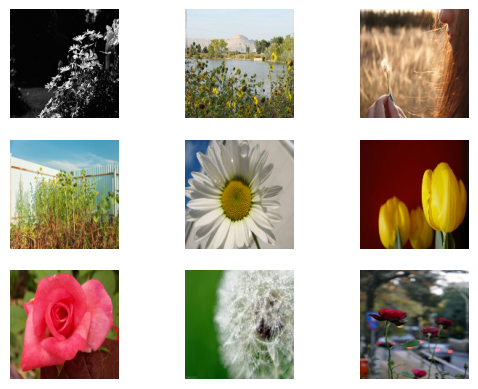

In [ ]:
import matplotlib.pyplot as plt

# Take one batch from the dataset
for batch, batch in train_data.take(1):
    # Iterate through images in the batch
    for i in range(9):  # Show 9 images for preview
        plt.subplot(3, 3, i + 1)
        plt.imshow(batch[i].numpy().clip(0, 1))  # Clip values to [0, 1] range
        plt.axis('off')
    plt.show()


## 2. Define the autoencoder Model

You will use convolutional layers to build the autoencoder model.

**Hints**:
- You may refere to the scripts of *07_4_FashionMNIST_CNNAutoEncoder.ipynb* if you like
- If you use the code from there, make sure you understand that the input images in FashionMNIST are (28,28,1), but our flower images are (150,150,3). You need to make adjustments whereever necessary.

### 2.1 The encoder

**Task 3: Encoder**:

- Define your encoder (**on your own choices**) that contain conv2d and max pooling layers on your own choices.
- Optionally, you also can have bottleneck (like the one used in *07_4_FashionMNIST_CNNAutoEncoder.ipynb*). **Note**: A bottleneck layer is used to get more features but without further reducing the dimension afterwards. Another layer is inserted here for visualizing the encoder output.

In [ ]:
def encoder(inputs):
    '''Defines the encoder with two Conv2D and max pooling layers.'''

    pass

In [ ]:
# this is optional, you may have this if you follow scripts of 07_4_FashionMNIST_CNNAutoEncoder.ipynb
def bottle_neck(inputs):
    '''Defines the bottleneck.'''
    pass

### 2.2 The decoder

**Task 4: Decoder**:

Define your decoder **on your own choices**, but you may follow the common strategies:

- **Mirror the Encoder Architecture**. If the encoder uses convolutional layers, the decoder generally uses transposed convolutional layers (Conv2DTranspose).
- **Activation Functions**. The final layer should use an activation function that matches the data characteristics, i.e., Sigmoid for pixel values in the range [0, 1]. Intermediate layers can use ReLU or LeakyReLU.
- **Final Output Layer**: In general, you should have the same number of channels and spatial dimensions as the original input image i.e., (150,150,0). So, you may use **ZeroPadding2D** to fill the gap.

In [ ]:
from threading import active_count
def decoder(inputs):
    '''Defines the decoder path to upsample back to the original image size.'''

    pass


### 2.3 Autoencoder

**Task 5: AutoEncoder**:

You will builds the entire autoencoder model based on the encoder layer and decoder layers you define above. You may return all three models:
- **Encoder model**: This model can be used for predicing latent space
- **Decoder model**: This model can be used for generating new images. This model is optional if no imgae generation task is performed.
- **Autoencoder model**: This model will be used for model fitting and model prediction.

You may print out the autoencoder model using model summary.

In [ ]:
def convolutional_auto_encoder():
    '''Builds the entire autoencoder model.'''

    pass


In [ ]:
# you may need to chnage the following code depending on  how you implement the convolutional_auto_encoder above.
convolutional_model, convolutional_encoder_model, convolutional_decoder_model = convolutional_auto_encoder()
convolutional_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 37, 37, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 74, 74, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 74, 74, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 148, 148, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 148, 148, 3)         │           1,731 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d (ZeroPadding2D)       │ (None, 150, 150, 3)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 741,379 (2.83 MB)

 Trainable params: 741,379 (2.83 MB)

 Non-trainable params: 0 (0.00 B)

## 3. Compile and Train the model

**Task 6: Compile and Train the model**:

- Configure model compile optimizer and loss function, the suggested ones are:
  - optimizer: adan
  - loss: mse (mean squared error)
- Do model fitting on your **train_data** from Section 1.2.3, set epochs to 10. **Note**: It takes long if you increase large epoch value, say 40.

In [ ]:
# your model compile and model fitting

pass

## 4. Display sample results

### 4.1 Visualization functions

**Task 7: Visualization functions**:

Do the followings:
- Understand each of the following functions
- Make necessary changes if the embedding representations in your encoder model (my encoder representation is (37,37,3)) is not same as the one I provide below.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def display_one_row(disp_images, offset, shape=(150, 150,3)):
    '''Display sample outputs in one row.'''
    for idx, test_image in enumerate(disp_images):
        plt.subplot(3, 10, offset + idx + 1)
        plt.xticks([])
        plt.yticks([])
        test_image = np.reshape(test_image, shape)
        plt.imshow(test_image)

def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(37,37,3)):
    '''Displays the input, encoded, and decoded output values.'''
    plt.figure(figsize=(15, 5))
    display_one_row(disp_input_images, 0, shape=(150,150,3))
    display_one_row(disp_encoded, 10, shape=enc_shape)
    display_one_row(disp_predicted, 20, shape=(150,150,3))

### 4.2 Prepare testing images

In [ ]:
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

# load the dataset
# take 1 batch of the dataset
test_dataset = train_data.take(1)

# take the input images and put them in a list
output_samples = []
for input_image, image in tfds.as_numpy(test_dataset):
    output_samples = input_image

# pick 10 indices
idxs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# prepare test samples as a batch of 10 images
conv_output_samples = np.array(output_samples[idxs])
conv_output_samples = np.reshape(conv_output_samples, (10, 150,150,3))

### 4.3 Visualize original images, embeddings and reconstructed images

**Task 8: Visualize original images, embeddings and reconstructed images**:

You will perform the following tasks:
- Get the encoder ouput through using the encoder model to predict the sample images: **conv_output_samples**.
- Get a reconstructed results through using the autoencoder model to predict the sample images: **conv_output_samples**.
- Display the samples, encodings and decoded values using the function of **display_results**.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


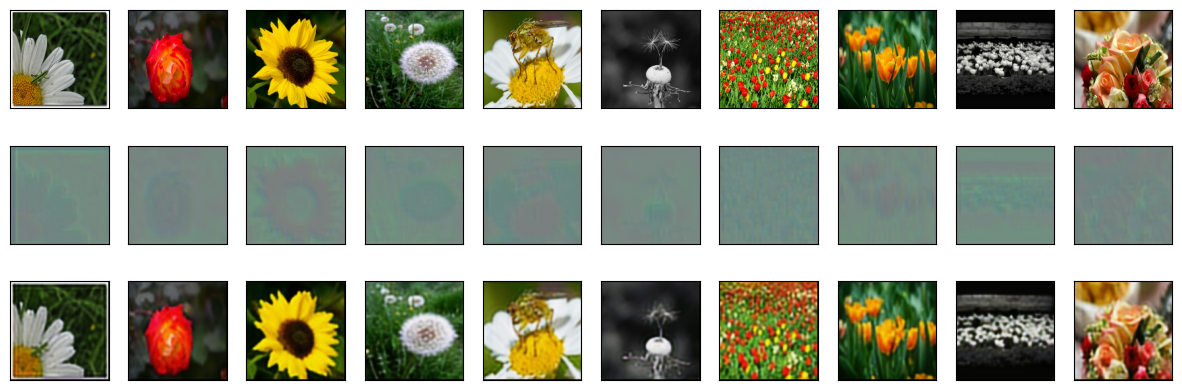

In [ ]:
# Your source code below





